In [1]:
import torch
import torch.nn.functional as F
from torch import nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt # for making figures
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from sklearn.manifold import TSNE
from pprint import pprint
import urllib.request
import random
import re
import torch._dynamo
import os
from torch.optim.lr_scheduler import StepLR

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
url = "https://www.gutenberg.org/files/1661/1661-0.txt"
response = urllib.request.urlopen(url)
sherlock_text = response.read().decode("utf-8")
sherlock_text = sherlock_text[1504:]

In [4]:
def generate_word_prediction_dataset(text, block_size=5, print_limit=20):
    """
    Generates a dataset for word-based prediction from input text.
    
    Args:
        text (str): Input text to process.
        block_size (int): Number of words used as context to predict the next word.
        print_limit (int): Number of (context, target) pairs to print for visualization.

    Returns:
        X (torch.Tensor): Input tensor containing contexts.
        Y (torch.Tensor): Output tensor containing target word indices.
        stoi (dict): String-to-index mapping of words.
        itos (dict): Index-to-string mapping of words.
    """
    # Step 1: Split the text into sentences using regex
    sentences = re.split(r'\.\s+|\r\n\r\n', text)

    # Step 2: Clean each sentence and tokenize into words
    cleaned_sentences = [
        re.sub(r'[^a-zA-Z0-9 ]', ' ', sentence).strip()
        for sentence in sentences
    ]

    # **Filter out sentences with fewer than two words**
    cleaned_sentences = [s for s in cleaned_sentences if len(s.split()) >= 2]

    words = [word for sentence in cleaned_sentences for word in sentence.split()]

    # Step 3: Create vocabulary and mappings
    vocabulary = set(words)
    
    stoi = {word: i + 1 for i, word in enumerate(vocabulary)}
    stoi["."] = 0  # Sentence-end marker
    itos = {i: word for word, i in stoi.items()}
    itos[0] = "."  # Ensure "." is included in `itos`

    X, Y = [], []  # Inputs and targets
    count = 0  # Counter for visualization

    # Step 4: Generate (X, Y) pairs using a sliding window over sentences
    for sentence in cleaned_sentences:
        sentence_words = sentence.split()  # Tokenize sentence into words

        # Initialize context with zeros (padding)
        context = [0] * block_size  
        for word in sentence_words + ['.']:  # Include "." as sentence-end marker
            ix = stoi[word]  # Get index of the current word
            X.append(context)  # Add current context to inputs
            Y.append(ix)  # Add target word index to outputs

            # Print context-target pairs (limited by `print_limit`)
            if count < print_limit:
                print(' '.join(itos[i] for i in context), '--->', itos[ix])
                count += 1

            # Slide the context window by one word
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)

    print(f"Dataset generated with {len(X)} samples")
    return X, Y, stoi, itos

X, Y, stoi, itos = generate_word_prediction_dataset(sherlock_text, block_size=5, print_limit=20)

. . . . . ---> A
. . . . A ---> SCANDAL
. . . A SCANDAL ---> IN
. . A SCANDAL IN ---> BOHEMIA
. A SCANDAL IN BOHEMIA ---> .
. . . . . ---> To
. . . . To ---> Sherlock
. . . To Sherlock ---> Holmes
. . To Sherlock Holmes ---> she
. To Sherlock Holmes she ---> is
To Sherlock Holmes she is ---> always
Sherlock Holmes she is always ---> the
Holmes she is always the ---> woman
she is always the woman ---> .
. . . . . ---> I
. . . . I ---> have
. . . I have ---> seldom
. . I have seldom ---> heard
. I have seldom heard ---> him
I have seldom heard him ---> mention
Dataset generated with 115262 samples


In [5]:
print("X tensor shape:", X.shape)
print("y tensor shape:", Y.shape)


X tensor shape: torch.Size([115262, 5])
y tensor shape: torch.Size([115262])


In [6]:
class NextWord(nn.Module):
    
    def __init__(self, block_size, vocab_size, emb_dim, hidden_size, activation_fn='ReLU'):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim)
        self.lin1 = nn.Linear(block_size * emb_dim, hidden_size)
        self.lin2 = nn.Linear(hidden_size, vocab_size)
        if activation_fn == 'ReLU':
            self.activation = nn.ReLU()
        elif activation_fn == 'Tanh':
            self.activation = nn.Tanh()
        else:
            raise ValueError("Unsupported activation function. Use 'relu' or 'tanh'.")

    def forward(self, x):
        x = self.emb(x)
        x = x.view(x.shape[0], -1)
        x = self.activation(self.lin1(x))  # Apply activation function
        x = self.lin2(x)
        return x


In [7]:
def save_model(model, embedding_size, context_length, activation_fn):
    # Create a name based on parameters
    model_name = f"model_emb{embedding_size}_ctx{context_length}_act{activation_fn}.pth"
    
    # Save the model state dictionary
    torch.save(model.state_dict(), model_name)
    print(f"Model saved as {model_name}")


In [8]:
def generate_text(model, itos, stoi, block_size, input_sentence, max_len=100):
    # Convert the input sentence to a list of word indices
    input_indices = [stoi.get(word, 0) for word in input_sentence.split()]  # 0 for unknown words
    
    # Initialize context with the last `block_size` indices of the input sentence
    context = [0] * max(0, block_size - len(input_indices)) + input_indices[-block_size:]
    generated_text = input_sentence.strip() + ' '
    
    for _ in range(max_len):
        x = torch.tensor(context).view(1, -1).to(device)
        y_pred = model(x)
        
        # Sample the next word
        ix = torch.distributions.categorical.Categorical(logits=y_pred).sample().item()
        next_word = itos[ix]
        
        # Append the generated word to the text
        generated_text += next_word + ' '
        
        # Update the context
        context = context[1:] + [ix]
    
    # Remove spaces before periods
    generated_text = generated_text.replace(' .', '.')
    
    return generated_text.strip()

In [14]:
os.environ["PYTORCH_ENABLE_TRITON"] = "0"
torch._dynamo.config.suppress_errors = True
# torch._dynamo.config.verbose=True

loss_fn = nn.CrossEntropyLoss()

hidden_size = 1024
batch_size = 4096
print_every =50
num_epochs = 500

for emb_dim in [64]:
    for block_size in [10]:
        for activation_function in ["ReLU"]:
            X_tensor, y_tensor, stoi, itos = generate_word_prediction_dataset(sherlock_text, block_size = block_size, print_limit = 10)
            model = NextWord(block_size, len(stoi), emb_dim, hidden_size, activation_function).to(device)
            
            opt = torch.optim.AdamW(model.parameters(), lr=0.01)
            scheduler = StepLR(opt, step_size=50, gamma=0.1)
            X_tensor.to(device)
            y_tensor.to(device)
            for epoch in range(num_epochs):
                for i in range(0, X_tensor.shape[0], batch_size):
                    x = X_tensor[i:i + batch_size].to(device)
                    y = y_tensor[i:i + batch_size].to(device)
                    y_pred = model(x)
                    loss = loss_fn(y_pred, y)
                    loss.backward()
                    opt.step()
                    opt.zero_grad()
                scheduler.step()
                if (epoch+1) % print_every == 0:
                    print(f"Epoch: {epoch+1}, Loss: {loss.item()}")
            save_model(model, emb_dim, block_size, activation_function)
           

. . . . . . . . . . ---> A
. . . . . . . . . A ---> SCANDAL
. . . . . . . . A SCANDAL ---> IN
. . . . . . . A SCANDAL IN ---> BOHEMIA
. . . . . . A SCANDAL IN BOHEMIA ---> .
. . . . . . . . . . ---> To
. . . . . . . . . To ---> Sherlock
. . . . . . . . To Sherlock ---> Holmes
. . . . . . . To Sherlock Holmes ---> she
. . . . . . To Sherlock Holmes she ---> is
Dataset generated with 115262 samples
Epoch: 50, Loss: 0.41227248311042786
Epoch: 100, Loss: 0.38913124799728394
Epoch: 150, Loss: 0.38712647557258606
Epoch: 200, Loss: 0.3869479298591614
Epoch: 250, Loss: 0.3869316279888153
Epoch: 300, Loss: 0.38693052530288696
Epoch: 350, Loss: 0.386930376291275
Epoch: 400, Loss: 0.3869304060935974
Epoch: 450, Loss: 0.3869304060935974
Epoch: 500, Loss: 0.3869304060935974
Model saved as model_emb64_ctx10_actReLU.pth


In [11]:
# Generate sample words
input = "Hi"
print(generate_text(model, itos, stoi, block_size,input, 1000))


Hi Jabez Wilson.. up and he had known to the room that was the small place days of his s house. works to set no great girl than erred perhaps 2 criminals. studies. about director from her terrible suggestive to her give. some gentleman to her to tell his her but when they got to the loss and a 7 little put. a which he had fingers again. the mystery half a argument to meet at her injured round who loves her but pedestrians with a pointing of them her own little and so far that he is does a horrible fare between the hundred from 7 of the addition I have sister was emerge in some safety. of jealousy. with the eyes of the man and and was my advice. for that the coronet. be up for the banker and taken a mere larger than his was a for easy. deep had been worth him and that was that the envelope was in his story standing without Park for his well. for a moment was was a when for me had no good to the station of the most singular which was so so. of the time that she was naturally up for down 

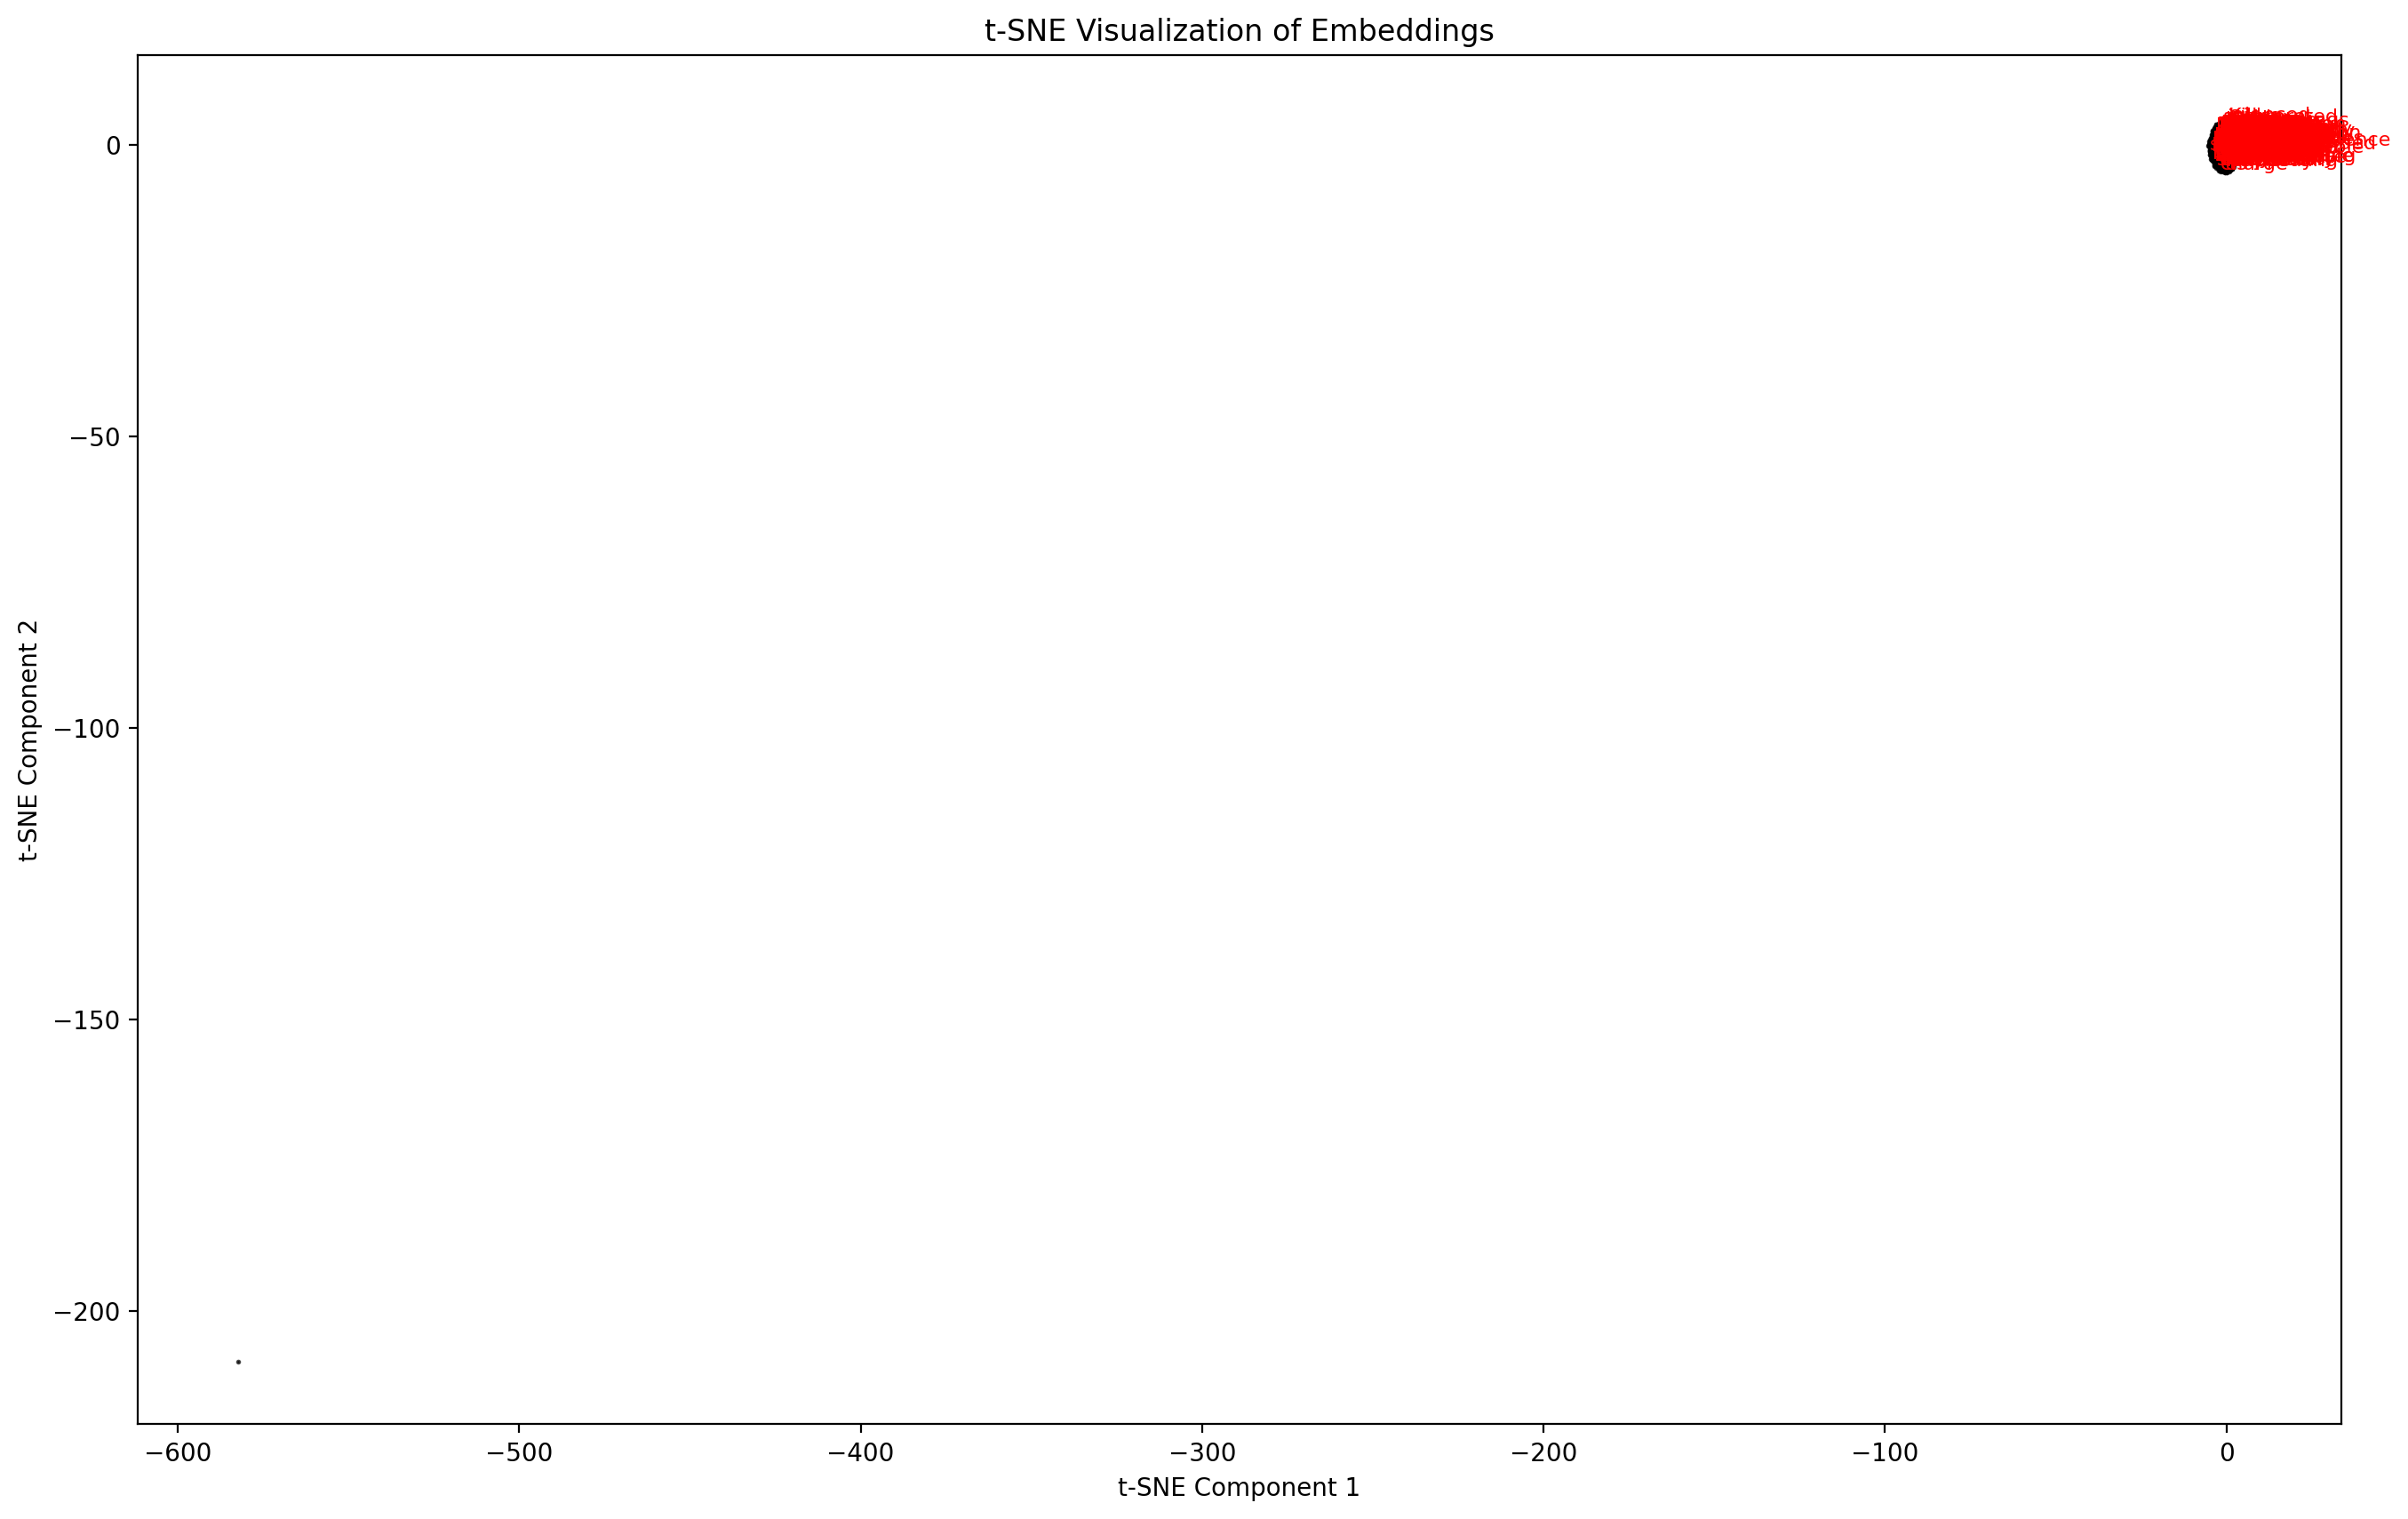

In [15]:
def plot_emb(emb, itos, ax=None, num_points_to_label=100):
    if ax is None:
        fig, ax = plt.subplots(figsize=(16, 10))
        
    # Extract the embedding weights
    emb_weights = emb.weight.detach().cpu().numpy()
    
    # Apply t-SNE to reduce dimensions
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=300)
    emb_2d = tsne.fit_transform(emb_weights)

    # Scatter plot the t-SNE results
    ax.scatter(emb_2d[:, 0], emb_2d[:, 1], color='k', s=1, alpha=0.7)

    # Randomly select a subset of points to label
    indices = np.random.choice(len(itos), num_points_to_label, replace=False)

    # Annotate each selected point with the corresponding word
    for i in indices:
        ax.text(emb_2d[i, 0] + 0.05, emb_2d[i, 1] + 0.05, itos[i], fontsize=8, color='red')
        
    ax.set_title('t-SNE Visualization of Embeddings')
    ax.set_xlabel('t-SNE Component 1')
    ax.set_ylabel('t-SNE Component 2')
    
    return ax

# Example usage with num_points_to_label as a keyword argument
plot_emb(model.emb, itos, num_points_to_label=300)
plt.show()


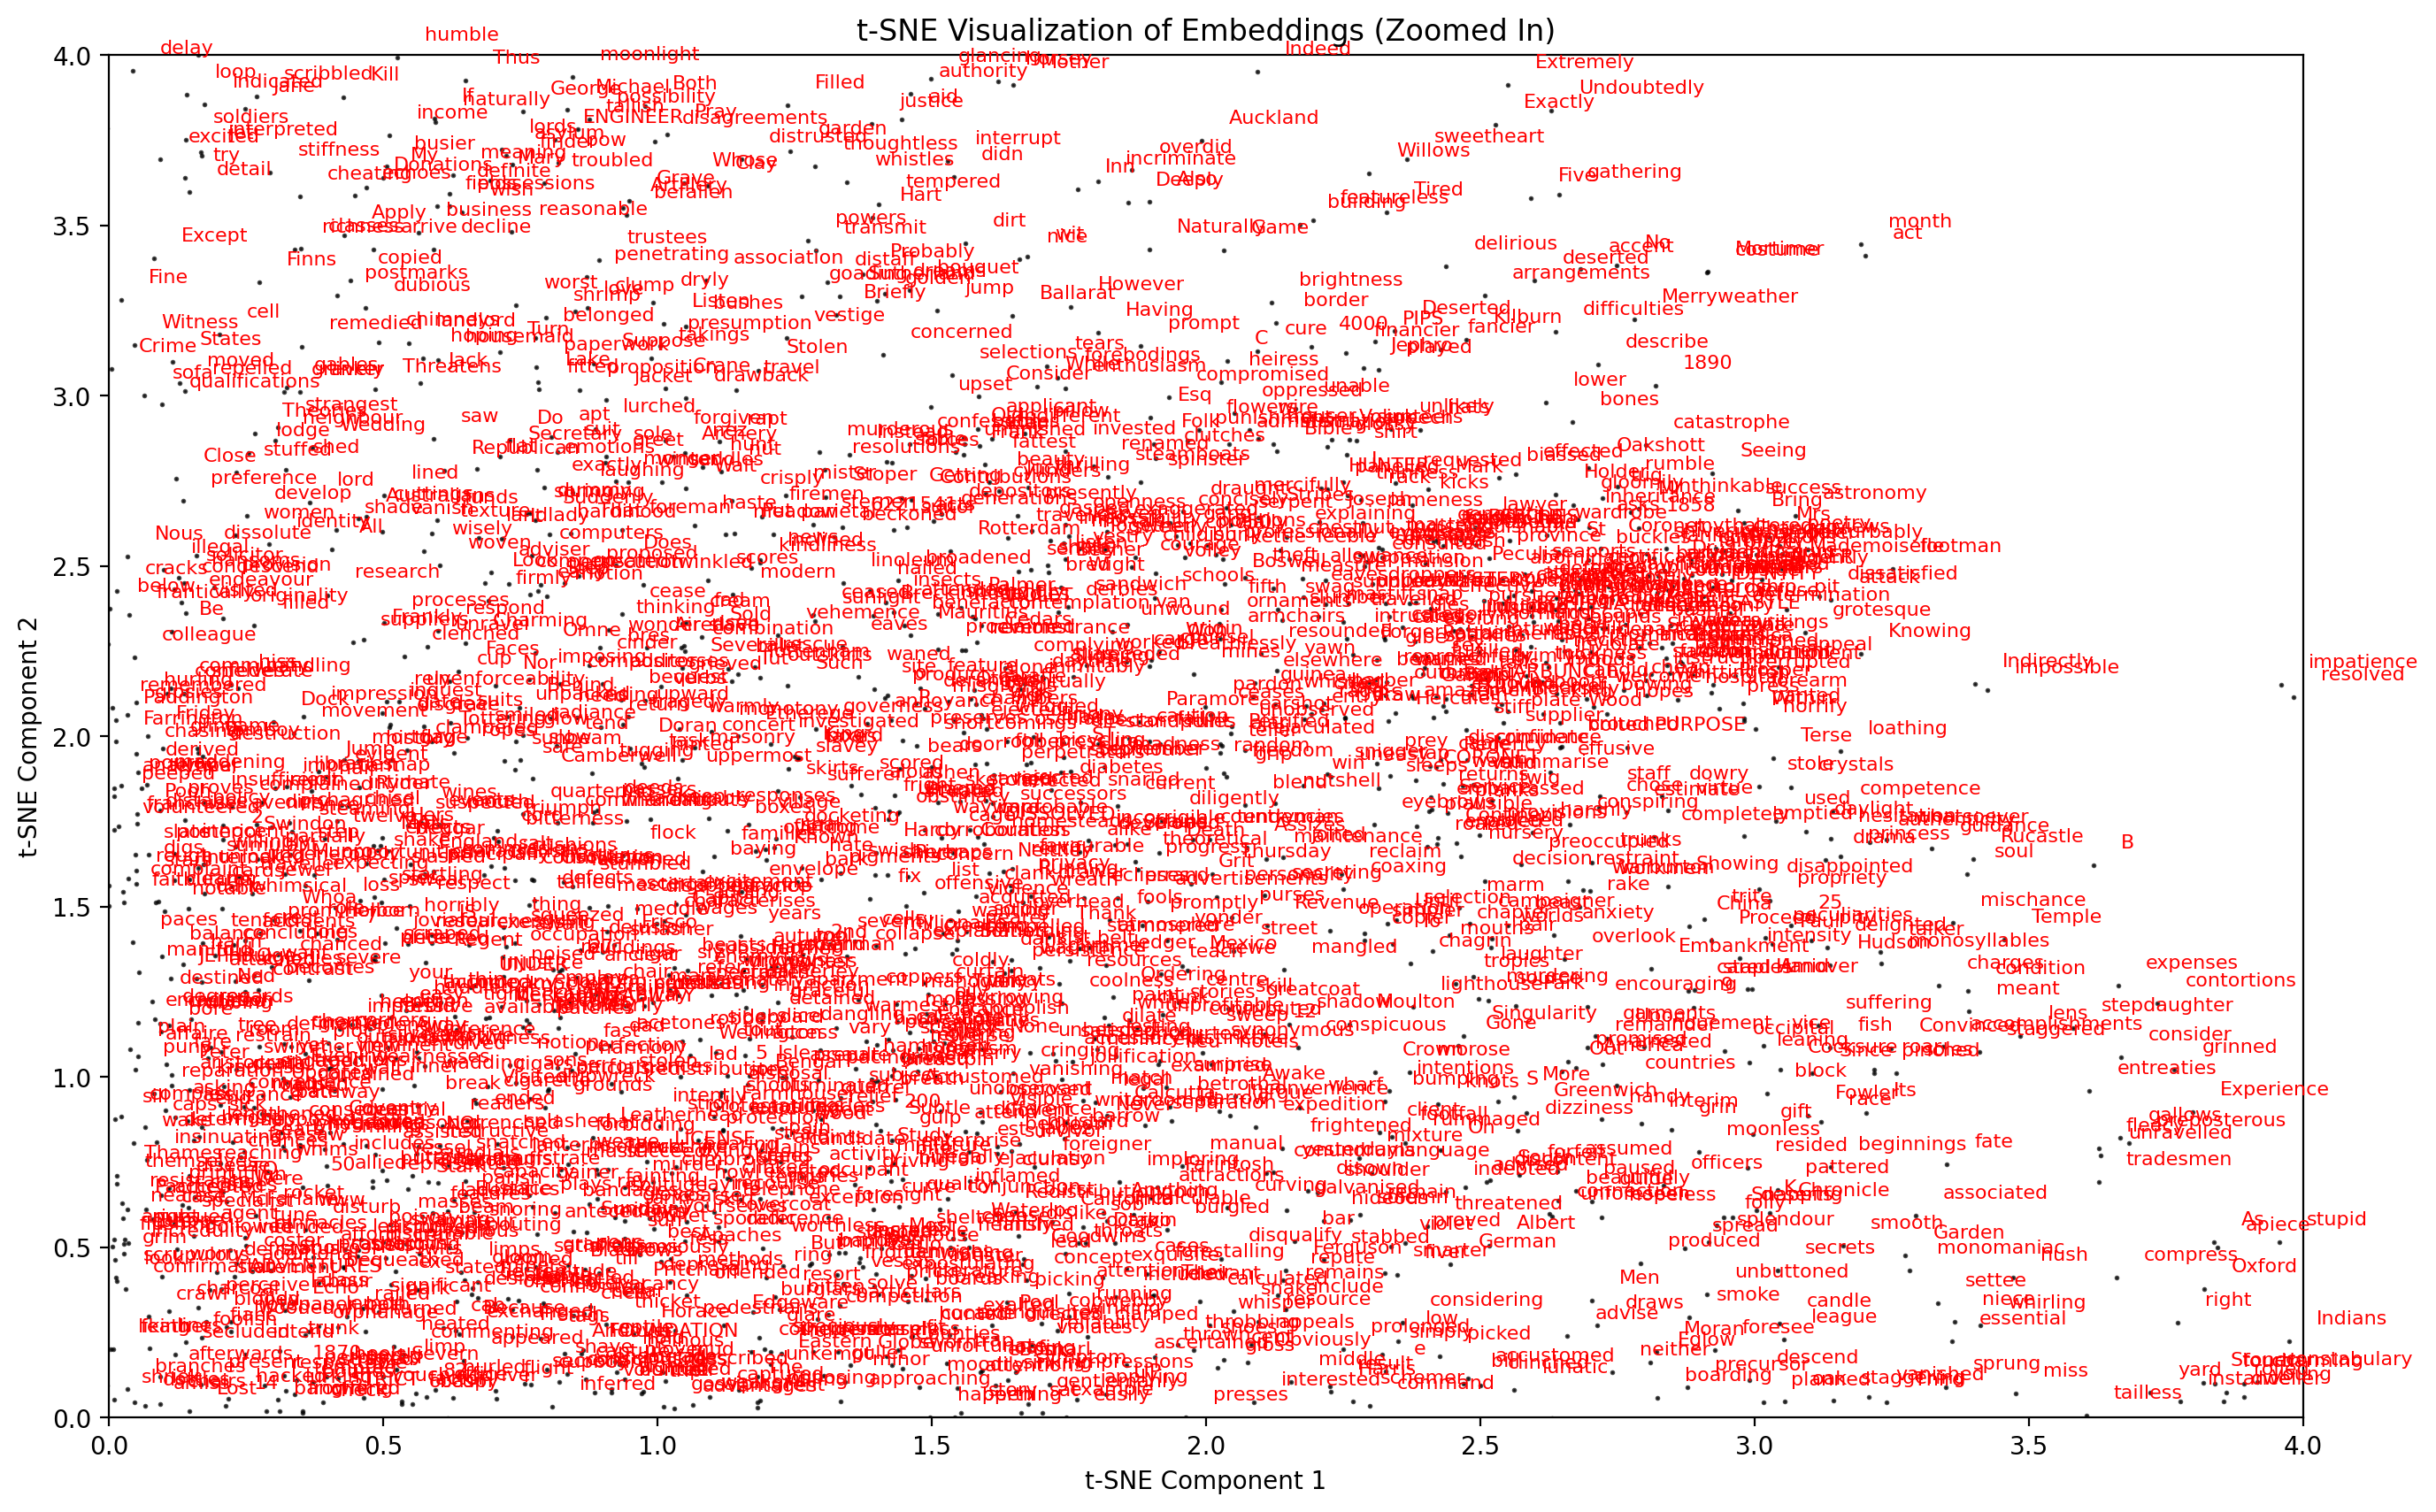

In [16]:
def plot_emb(emb, itos, ax=None, num_points_to_label=100, x_range=None, y_range=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(16, 10))
        
    # Extract the embedding weights
    emb_weights = emb.weight.detach().cpu().numpy()
    
    # Apply t-SNE to reduce dimensions
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=300)
    emb_2d = tsne.fit_transform(emb_weights)

    # Scatter plot the t-SNE results
    ax.scatter(emb_2d[:, 0], emb_2d[:, 1], color='k', s=1, alpha=0.7)

    # If ranges are specified, filter the points within the specified region
    if x_range and y_range:
        mask = (emb_2d[:, 0] > x_range[0]) & (emb_2d[:, 0] < x_range[1]) & \
               (emb_2d[:, 1] > y_range[0]) & (emb_2d[:, 1] < y_range[1])
        indices = np.where(mask)[0]
    else:
        # Randomly select a subset of points to label if no range is specified
        indices = np.random.choice(len(itos), num_points_to_label, replace=False)

    # Annotate each selected point with the corresponding word
    for i in indices:
        ax.text(emb_2d[i, 0] + 0.05, emb_2d[i, 1] + 0.05, itos[i], fontsize=8, color='red')
        
    # Set the plot limits to zoom into the specified range
    if x_range:
        ax.set_xlim(x_range)
    if y_range:
        ax.set_ylim(y_range)
        
    ax.set_title('t-SNE Visualization of Embeddings (Zoomed In)')
    ax.set_xlabel('t-SNE Component 1')
    ax.set_ylabel('t-SNE Component 2')
    
    return ax

# Example usage with a specific range to zoom in on
plot_emb(model.emb, itos, num_points_to_label=50, x_range=(0, 4), y_range=(0, 4))
plt.show()
